# Importing Libraries and Setting Parameters
This cell imports all the necessary Python libraries and sets up key parameters for the trading scanner:

- **yfinance**: For downloading stock price data.
- **pandas**: For data manipulation and analysis.
- **numpy**: For numerical operations.
- **matplotlib.pyplot**: For plotting and visualizations.
- **datetime**: For handling dates and time periods.

It also sets the plotting style to 'fivethirtyeight' for better visuals and enables inline plotting in the notebook. The cell defines standard parameters such as lookback period, moving average windows, RSI and ATR periods, account size, risk per trade, and ATR multiplier. These parameters are used throughout the scanner to control data range, indicator calculations, and risk management.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Plotting style
plt.style.use('fivethirtyeight')
%matplotlib inline

# Standard Parameters
LOOKBACK_YEARS = 1
END_DATE = datetime.datetime.today()
START_DATE = END_DATE - datetime.timedelta(days=LOOKBACK_YEARS*365)
MA_SHORT = 20 # 20-period MA
MA_MED = 50 # 50-period MA
MA_LONG = 200 # 200-period MA
RSI_PERIOD = 14 # 14-period RSI
ATR_PERIOD = 14 # 14-period ATR
VOL_MA_PERIOD = 20 # 20-period Volatility MA

ACCOUNT_SIZE = 3000 # $3000 account size
RISK_PER_TRADE = 0.20 # 20% of account size
ATR_MULTIPLIER = 2.0 # 2x ATR

# Fetching Ticker Symbols and Sectors
This cell defines functions to fetch and organize ticker symbols and their sectors for both the S&P 500 (US) and TSX (Canada) stock markets:

- **TICKER_SECTORS**: A global dictionary to map each ticker symbol to its sector.
- **get_sp500_tickers_and_sectors()**: Scrapes the S&P 500 company list from Wikipedia, extracting ticker symbols and their sectors, and populates the global map.
- **get_tsx_tickers_and_sectors()**: Scrapes the TSX Composite Index from Wikipedia, extracting ticker symbols (with ".TO" suffix) and their sectors, and updates the global map.
- Both functions handle errors gracefully and return a default list if scraping fails.
- The code then fetches both lists, combines them into a single `TICKERS` list, and prints the number of tickers loaded for further analysis.

In [2]:
# Global map to hold ticker to sector mapping
TICKER_SECTORS = {}

def get_sp500_tickers_and_sectors():
    """Scrapes Symbol and Sector from Wikipedia"""
    try:
        import requests
        import io
        url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers)
        df = pd.read_html(io.StringIO(response.text))[0]
        
        # Populate the global map
        for index, row in df.iterrows():
            sym = row['Symbol'].replace('.', '-')
            sector = row['GICS Sector']
            TICKER_SECTORS[sym] = sector
            
        return list(TICKER_SECTORS.keys())
    except Exception as e:
        print(f"Error fetching S&P 500: {e}")
        return ['SPY', 'AAPL', 'MSFT']

def get_tsx_tickers_and_sectors():
    """Scrapes Symbol and Sector from Wikipedia for TSX"""
    try:
        import requests
        import io
        url = 'https://en.wikipedia.org/wiki/S%26P/TSX_Composite_Index'
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers)
        
        # Find table with 'Ticker' column
        tables = pd.read_html(io.StringIO(response.text))
        df = next(t for t in tables if 'Ticker' in t.columns)
        
        print("TSX columns:", df.columns)

        tickers = []
        # Find the sector column dynamically
        sector_col = None
        for col in df.columns:
            if 'sector' in col.lower():
                sector_col = col
                break

        for index, row in df.iterrows():
            sym = str(row['Ticker']).replace('.', '-')
            if sector_col and pd.notnull(row[sector_col]):
                sector = row[sector_col]
            else:
                sector = 'Canadian Market'
            sym_to = sym + ".TO"
            TICKER_SECTORS[sym_to] = sector
            tickers.append(sym_to)

        return tickers

    except Exception as e:
        print(f"Error fetching TSX list: {e}")
        return ['SHOP.TO', 'RY.TO', 'TD.TO']

# Load Both Lists
print("Fetching tickers and sectors...")
sp500 = get_sp500_tickers_and_sectors()
tsx = get_tsx_tickers_and_sectors()

# Combine them
TICKERS = sp500 + tsx

print(f"Loaded {len(sp500)} US and {len(tsx)} Canadian tickers. Total: {len(TICKERS)}")

sample_items = list(TICKER_SECTORS.items())[:3]
df_sample = pd.DataFrame(sample_items, columns=["Ticker", "Sector"])
print("Ticker to Sector mapping sample:")
display(df_sample)

# TSX Ticker to Sector mapping sample (first 3)
tsx_head = [ticker for ticker in TICKER_SECTORS if ticker.endswith('.TO')]
tsx_sample = [(ticker, TICKER_SECTORS[ticker]) for ticker in tsx_head[:3]]
df_tsx_sample = pd.DataFrame(tsx_sample, columns=["TSX Ticker", "Sector"])
print("TSX Ticker to Sector mapping sample:")
display(df_tsx_sample)

Fetching tickers and sectors...
TSX columns: Index(['Ticker', 'Company', 'Sector [9]', 'Industry [9]'], dtype='object')
Loaded 503 US and 223 Canadian tickers. Total: 726
Ticker to Sector mapping sample:


,Ticker,Sector
0,MMM,Industrials
1,AOS,Industrials
2,ABT,Health Care


TSX Ticker to Sector mapping sample:


,TSX Ticker,Sector
0,AAV.TO,Energy
1,AEM.TO,Basic Materials
2,AC.TO,Industrials


# Core Functions for Data Processing and Strategy Application

This cell defines the core functions that power the swing trading scanner:

- **`download_data(tickers, start, end)`**: Downloads historical OHLCV (Open, High, Low, Close, Volume) data for a list of ticker symbols using the yfinance library. It handles bulk downloads efficiently, cleans the data by removing NaN values, and returns a dictionary of DataFrames keyed by ticker symbol. This function is crucial for fetching the raw market data needed for analysis.

- **`calculate_indicators(df)`**: Adds a comprehensive set of technical indicators to a stock's DataFrame. These include moving averages (SMA 20, 50, 200), volume metrics (SMA of volume and relative volume), momentum indicators (RSI, MACD), volatility measures (Bollinger Bands, ATR), oscillators (Stochastic K/D), trend strength (ADX), cycle indicators (CCI), and anchored VWAP. It also computes returns and rolling highs for filtering purposes. This function transforms raw price data into actionable technical signals.

- **`check_market_regime(market_ticker='SPY', start_date=START_DATE, end_date=END_DATE)`**: Evaluates the overall market trend by comparing the market index (default SPY) to its 200-period simple moving average. It returns True if the market is in an uptrend (price above 200 SMA), which influences the probability of successful long trades. This helps filter out setups during bearish market conditions.

- **`apply_strategies(df)`**: Implements four swing trading strategies by defining boolean conditions for each:
  1. **Breakout**: Identifies strong upward breakouts above 20-day highs with high volume and trend strength (ADX > 20).
  2. **Pullback**: Finds dips near the 20 SMA in an uptrending market (20 > 50 > 200 SMAs) with moderate volume and RSI in a neutral range.
  3. **Mean Reversion**: Spots oversold bounces below the lower Bollinger Band with Stochastic K < 20, above the 200 SMA.
  4. **Retest**: Detects pullbacks to recently broken resistance levels with drying volume, indicating potential continuation.

These functions work together to process raw data, compute indicators, assess market conditions, and generate trading signals, forming the backbone of the automated scanner.

In [3]:
def download_data(tickers, start, end):
    """
    Downloads daily OHLCV data for a list of tickers using yfinance.
    Returns a dictionary of DataFrames.
    """
    data_dict = {}
    print(f"Downloading data for {len(tickers)} tickers...")
    
    # Bulk download is faster. Added progress=False to keep notebook clean.
    try:
        raw_data = yf.download(tickers, start=start, end=end, group_by='ticker', auto_adjust=True, threads=True, progress=False)
        
        for ticker in tickers:
            # Handle case where only one ticker is downloaded
            if len(tickers) == 1:
                # Fix: Check if it's a MultiIndex (common with group_by='ticker')
                if isinstance(raw_data.columns, pd.MultiIndex):
                    df = raw_data[ticker].copy()
                else:
                    df = raw_data.copy()
            else:
                # Check if ticker is in columns (handling delisted/errors)
                if ticker not in raw_data.columns.levels[0]:
                    # print(f"Warning: No data for {ticker}") # Uncomment to debug missing tickers
                    continue
                df = raw_data[ticker].copy()
            
            # Basic cleaning
            df.dropna(inplace=True)
            if df.empty:
                continue
                
            data_dict[ticker] = df
            
    except Exception as e:
        print(f"Error downloading data: {e}")
        
    print(f"Successfully loaded {len(data_dict)} tickers.")
    return data_dict

def calculate_indicators(df):
    """
    Adds technical indicators to the DataFrame (Pro Version).
    Includes: SMA, Volume SMA, RSI, MACD, Bollinger Bands, ATR, Stochastics, ADX, CCI, AVWAP.
    """
    if df.empty:
        return df
        
    df = df.copy()
    
    # Constants
    MA_SHORT = 20
    MA_MED = 50
    MA_LONG = 200
    RSI_PERIOD = 14
    ATR_PERIOD = 14
    VOL_MA_PERIOD = 20
    
    # 1. Moving Averages
    df[f'SMA_{MA_SHORT}'] = df['Close'].rolling(window=MA_SHORT).mean()
    df[f'SMA_{MA_MED}'] = df['Close'].rolling(window=MA_MED).mean()
    df[f'SMA_{MA_LONG}'] = df['Close'].rolling(window=MA_LONG).mean()
    
    # 2. Volume Moving Average
    df['Vol_SMA'] = df['Volume'].rolling(window=VOL_MA_PERIOD).mean()
    df['Rel_Vol'] = df['Volume'] / df['Vol_SMA']
    
    # 3. RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=RSI_PERIOD).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=RSI_PERIOD).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # 4. MACD (Momentum)
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
    
    # 5. Bollinger Bands (20, 2)
    std_dev = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df[f'SMA_{MA_SHORT}'] + (2 * std_dev)
    df['BB_Lower'] = df[f'SMA_{MA_SHORT}'] - (2 * std_dev)
    
    # 6. ATR (Average True Range)
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['ATR'] = true_range.rolling(window=ATR_PERIOD).mean()
    
    # 7. Slow Stochastics (14, 3)
    low_14 = df['Low'].rolling(window=14).min()
    high_14 = df['High'].rolling(window=14).max()
    df['Stoch_K'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
    df['Stoch_D'] = df['Stoch_K'].rolling(window=3).mean()
    
    # 8. ADX (Trend Strength)
    plus_dm = df['High'].diff()
    minus_dm = df['Low'].diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(df['High'] - df['Low'])
    tr2 = pd.DataFrame(abs(df['High'] - df['Close'].shift(1)))
    tr3 = pd.DataFrame(abs(df['Low'] - df['Close'].shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis=1, join='outer').max(axis=1)
    atr_adx = tr.rolling(14).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha=1/14).mean() / atr_adx)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/14).mean() / atr_adx))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    df['ADX'] = dx.ewm(alpha=1/14).mean()

    # 9. CCI (Commodity Channel Index)
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(window=20).mean()
    mad = tp.rolling(window=20).apply(lambda x: np.abs(x - x.mean()).mean())
    df['CCI'] = (tp - sma_tp) / (0.015 * mad)

    # 10. Anchored VWAP (Anchored to start of data)
    # Typical Price
    vwap_tp = (df['High'] + df['Low'] + df['Close']) / 3
    # Volume * Typical Price
    vp = vwap_tp * df['Volume']
    # Cumulative Total
    total_vp = vp.cumsum()
    total_vol = df['Volume'].cumsum()
    df['AVWAP'] = total_vp / total_vol

    # Returns & Highs for filtering
    df['Ret_1d'] = df['Close'].pct_change()
    df['Ret_3m'] = df['Close'].pct_change(63)
    df['High_20d'] = df['High'].rolling(window=20).max()
    
    return df

def check_market_regime(market_ticker='SPY', start_date=START_DATE, end_date=END_DATE):
    """
    Checks if the broad market is in a long-term uptrend.
    Returns True if Market Price > 200 SMA.
    """
    print(f"Checking market regime for {market_ticker}...")
    try:
        print(f"Downloading data for {market_ticker} from {start_date} to {end_date}...")
        df = yf.download(market_ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
        print(f"Downloaded data shape: {df.shape}")
        print(f"Data columns: {df.columns}")
        print(f"Data empty? {df.empty}")
        
        # Handle multi-index columns if they exist
        if isinstance(df.columns, pd.MultiIndex):
            print("Handling MultiIndex columns...")
            # Fix: Use level=1 ('Ticker') instead of level=0 ('Price')
            df = df.xs(market_ticker, axis=1, level=1)
            print(f"After xs: shape {df.shape}, columns {df.columns}")
            
        if df.empty:
            raise ValueError(f"No data downloaded for {market_ticker}")
            
        df['SMA_200'] = df['Close'].rolling(window=200).mean()
        print(f"SMA_200 calculated. Last SMA value: {df['SMA_200'].iloc[-1] if not df['SMA_200'].isna().all() else 'NaN'}")
        
        latest = df.iloc[-1]
        print(f"Latest row: {latest}")
        
        is_uptrend = latest['Close'] > latest['SMA_200']
        
        status = "BULLISH" if is_uptrend else "BEARISH"
        print(f"Market Status: {status} (Price: {latest['Close']:.2f} vs 200 SMA: {latest['SMA_200']:.2f})")
        
        if not is_uptrend:
            print("WARNING: Market is in a downtrend. Long setups have lower probability.")
            
        return is_uptrend
    except Exception as e:
        print(f"Error checking market regime: {e}")
        print(f"Exception type: {type(e)}")
        import traceback
        traceback.print_exc()  # This will show the full stack trace
        return True  # Default to True if check fails to avoid blocking

def apply_strategies(df):
    """
    Defines boolean signals for swing trading setups (Pro Version).
    Strategies:
    1. Breakout (Strong Vol, ADX > 20)
    2. Pullback (Super Trend, 20 SMA dip, RSI Reset)
    3. Mean Reversion (BB Lower + Oversold)
    4. Breakout Retest (Base -> Breakout -> Retest of Support)
    """
    if df.empty:
        return df

    # Constants (Match calculate_indicators)
    MA_SHORT = 20
    MA_MED = 50
    MA_LONG = 200
    
    # 1. Breakout Setup
    # Rule: Price breaks 20d High with STRONG Volume (> 2x average) and Trend Strength
    breakout_cond = (
        (df['Close'] >= df['High_20d'].shift(1)) &
        (df['Rel_Vol'] > 2) & 
        (df['Close'] > df[f'SMA_{MA_MED}']) &
        (df['Close'] > df['Open']) & # Bullish candle
        (df['ADX'] > 20) # Trend is strong enough to sustain breakout
    )
    
    # 2. Pullback in "Super Trend"
    # Trend: 20 > 50 > 200
    super_trend = (
        (df[f'SMA_{MA_SHORT}'] > df[f'SMA_{MA_MED}']) & 
        (df[f'SMA_{MA_MED}'] > df[f'SMA_{MA_LONG}'])
    )
    
    # Setup: Price dips near 20 SMA (within 2%)
    near_20sma = (df['Low'] <= df[f'SMA_{MA_SHORT}']) & (df['Close'] > df[f'SMA_{MA_SHORT}'] * 0.98)
    
    # Validation: RSI not overbought (>70) and not oversold (<30), just "cooling off"
    # Stricter: RSI < 60 for better R/R
    rsi_reset = (df['RSI'] > 40) & (df['RSI'] < 60)
    
    # Vol Check: Consolidation volume (0.25 < Vol < 1.5)
    vol_check = (df['Rel_Vol'] > 0.25) & (df['Rel_Vol'] < 1.5)
    
    pullback_cond = super_trend & near_20sma & rsi_reset & vol_check
    
    # 3. Mean Reversion (Oversold Bounce)
    # Setup: Price extended below lower Bollinger Band
    touched_band = (df['Low'] <= df['BB_Lower']) | (df['Low'].shift(1) <= df['BB_Lower'].shift(1))
    
    # Filter: Only take oversold bounces if we are above the 200 SMA (Primary Trend is Up)
    # Stochastics K < 20 (Oversold)
    stoch_oversold = df['Stoch_K'] < 20
    
    mean_rev_cond = touched_band & stoch_oversold & (df['Close'] > df[f'SMA_{MA_LONG}'])

    # 4. Base -> Breakout -> Retest (NEW)
    # Logic: Price broke a 50-day resistance recently, and is now testing it from above.
    
    # A. Identify Resistance (The "Base" Top)
    # We look at the Highs from 10 days ago backwards (window 10 to 60)
    resistance_level = df['High'].shift(10).rolling(window=50).max()
    
    # B. Did we break out recently? (In the last 10 days)
    # Check if the highest close in the last 10 days was significantly above resistance
    recent_high = df['Close'].rolling(window=10).max()
    was_breakout = recent_high > (resistance_level * 1.02) # At least 2% clearance
    
    # C. Are we retesting now?
    # Current Price is near the resistance level (+/- 3%)
    near_resistance = (
        (df['Close'] >= resistance_level * 0.97) & 
        (df['Close'] <= resistance_level * 1.03)
    )
    
    # D. Pullback Validation
    # We must be below the recent high (it's a pullback, not a continuation yet)
    is_pullback_action = df['Close'] < recent_high
    
    # E. Volume Dry Up (Crucial for Retests)
    dry_volume = df['Rel_Vol'] < 1.2
    
    retest_cond = was_breakout & near_resistance & is_pullback_action & dry_volume & (df['Close'] > df[f'SMA_{MA_LONG}'])
        
    # Assign signals
    df['Signal_Breakout'] = breakout_cond
    df['Signal_Pullback'] = pullback_cond
    df['Signal_MeanRev'] = mean_rev_cond
    df['Signal_Retest'] = retest_cond # <--- NEW SIGNAL
    
    return df

# Sector Analysis and Market Context

This cell performs sector-level analysis to enhance the stock scanner by incorporating market context and relative strength:

- **Sector ETF Mapping**: Defines a dictionary (`SECTOR_ETF_MAP`) that maps each stock sector (e.g., Technology, Health Care) to its corresponding sector ETF proxy (e.g., XLK for Technology, XLV for Health Care). This allows comparing individual stocks against their sector performance.

- **Market Regime Check**: Calls the `check_market_regime()` function to determine if the overall market (using SPY) is in an uptrend. This global context helps filter setups during bearish periods when long trades have lower success rates.

- **Sector Data Download**: Downloads historical data for all sector ETFs plus market indices (SPY for US, XIU.TO for Canada) using the `download_data()` function. This provides the foundation for sector performance calculations.

- **Sector Performance Calculation**: For each sector ETF, computes 3-month returns and checks if the ETF is above its 50-day SMA to determine short-term trend direction. Stores this in `sector_performance` dictionary, which will be used later to score stocks based on sector strength.

This analysis ensures that the scanner prioritizes stocks in strong sectors and avoids those in weak ones, improving the quality of trade setups by considering broader market dynamics.

In [4]:
# --- Sector Analysis ---
print("\n--- Sector Analysis ---")

# Map Sector Names to their ETF Proxies
SECTOR_ETF_MAP = {
    'Energy': 'XLE',
    'Information Technology': 'XLK',
    'Technology': 'XLK',
    'Communication Services': 'XLC',
    'Consumer Discretionary': 'XLY',
    'Consumer Staples': 'XLP',
    'Financials': 'XLF',
    'Financial Services': 'XLF',
    'Health Care': 'XLV',
    'Industrials': 'XLI',
    'Materials': 'XLB',
    'Basic Materials': 'XLB',
    'Real Estate': 'XLRE',
    'Utilities': 'XLU'
}
# Check Market Regime
market_uptrend = check_market_regime('SPY', START_DATE, END_DATE)

# --- Pre-Fetch Sector Data ---
print("Downloading Sector ETF Data...")

sector_etfs = list(set(SECTOR_ETF_MAP.values())) + ['SPY', 'XIU.TO']
sector_data = download_data(sector_etfs, START_DATE, END_DATE)

# Calculate Sector Momentum (3-Month Return)
sector_performance = {}

for etf, df in sector_data.items():
    if not df.empty:
        df['Ret_3m'] = df['Close'].pct_change(63)
        current_perf = df['Ret_3m'].iloc[-1]
        
        # Detect Short Term Trend (Price > 50 SMA)
        sma50 = df['Close'].rolling(50).mean().iloc[-1]
        is_uptrend = df['Close'].iloc[-1] > sma50
        
        sector_performance[etf] = {
            'Ret_3m': current_perf,
            'Uptrend': is_uptrend
        }
# Clearer print with explanations
print("\nSector Performance (Dual Criteria for Clarity):")
print("Note: 'BULL' = Current price > 50-day SMA (short-term trend up). 'BEAR' = Otherwise.")
print("3M Return is separate (longer-term performance). A sector can be 'BULL' even with negative returns if price > SMA.")
print("-" * 80)
print("\nSector Performance (3M):")
for etf, stats in sector_performance.items():
    trend = "BULL" if stats['Uptrend'] else "BEAR"
    print(f"{etf}: {stats['Ret_3m']*100:.1f}% ({trend})")


--- Sector Analysis ---
Checking market regime for SPY...
Downloaded data shape: (251, 5)
Data columns: MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])
Data empty? False
Handling MultiIndex columns...
After xs: shape (251, 5), columns Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
SMA_200 calculated. Last SMA value: 630.0360119628906
Latest row: Price
Close      6.922400e+02
High       6.954500e+02
Low        6.912500e+02
Open       6.945700e+02
Volume     7.049585e+07
SMA_200    6.300360e+02
Name: 2026-01-15 00:00:00, dtype: float64
Market Status: BULLISH (Price: 692.24 vs 200 SMA: 630.04)
Successfully loaded 13 tickers.

Sector Performance (Dual Criteria for Clarity):
Note: 'BULL' = Current price > 50-day SMA (short-term trend up). 'BEAR' = Otherwise.
3M Return is separate (longer-term performance). A secto

# Running the Scanner with Advanced Filtering (v2.1 - Improved Targets & Scoring)

This cell executes the complete swing trading scanner with **improved target logic** and **realistic R/R calculations**:

## Key Improvements in v2.1:

### 1. **Fixed Target Calculation for All Strategies**

| Strategy | Previous Target | v2.1 Target | Why |
|----------|-----------------|-------------|-----|
| **Breakout** | 3x risk | 3x risk | ✅ Unchanged (works well) |
| **Pullback** | 20d high only | 20d high + 1 ATR **or** 2.5x risk | Allows for new highs after bounce |
| **Retest** | Recent high only | Recent high + 1 ATR **or** 2x risk | Continuation plays expect new highs |
| **Mean Rev** | SMA or 2x risk | SMA or 2x risk | ✅ Unchanged (works well) |

**The Key Insight**: Pullbacks and Retests are *continuation* plays — we expect the stock to make NEW highs, not just return to prior highs. Adding 1 ATR extension captures this expectation.

### 2. **Scoring System (Max 100 points)**

| Tier | Category | Max Points | Description |
|------|----------|------------|-------------|
| 1 | Trend Quality | 25 | Price > 200 SMA (+15), All MAs aligned (+10) |
| 2 | Sector Strength | 20 | Sector uptrend (+10), 5%+ return (+5), 10%+ return (+5) |
| 3 | Relative Strength | 25 | Alpha vs sector: >25% (+25), >15% (+20), etc. |
| 4 | Setup Quality | 20 | Strategy-specific volume/momentum checks |
| 5 | R/R Quality | 10 | 3.5+ R/R (+10), 3.0+ (+7), 2.5+ (+4) |
| 6 | Momentum | 10 | MACD bullish (+5), ADX > 25 for trends (+5) |

### 3. **Market Context Indicator**
- Automatically detects when Mean Reversion dominates (signals correction phase)
- Provides actionable guidance based on signal distribution

### 4. **Output Columns**
- **Grade**: A (85+), B (70-84), C (55-69), D (<55)
- **Risk%**: Stop distance as percentage of entry price
- **RS_Sec/RS_Mkt**: Relative strength vs sector and market

In [ ]:
# Constants for Filtering
MIN_RR = 2.0  
MIN_DOL_VOL = 10_000_000 

results = []
data_store = {}

print("Running Pro Scanner v2.1 with Improved Scoring & R/R...")

# 1. Download Stocks (if not cached)
if 'raw_data_dict' not in locals():
    raw_data_dict = download_data(TICKERS, START_DATE, END_DATE)

# 2. Process each ticker
for ticker, df in raw_data_dict.items():
    # Skip insufficient data
    if len(df) < MA_LONG: continue
        
    df = calculate_indicators(df)
    
    # Liquidity Filter
    avg_dollar_vol = (df['Close'] * df['Volume']).rolling(20).mean().iloc[-1]
    if avg_dollar_vol < MIN_DOL_VOL: continue
    
    # --- PRO: Apply Strategy ---
    df = apply_strategies(df)
    data_store[ticker] = df
    latest = df.iloc[-1]
    
    active_signal = None
    if latest['Signal_Breakout']: active_signal = 'Breakout'
    elif latest['Signal_Pullback']: active_signal = 'Pullback'
    elif latest['Signal_MeanRev']: active_signal = 'Mean Reversion'
    elif latest['Signal_Retest']: active_signal = 'Retest'
        
    if active_signal:
        # --- Advanced Risk Management ---
        entry = latest['Close']
        atr = latest['ATR']
        
        # Stops (Strategy-specific)
        if active_signal == 'Mean Reversion':
            stop = entry - (atr * 1.5)
        elif active_signal == 'Retest':
            stop = entry - (atr * 1.5)
        else:
            stop = entry - (atr * 2.0)
            
        risk = entry - stop
        if risk <= 0: continue
        
        # --- FIX v2.1: Realistic TECHNICAL targets with extensions ---
        # The key insight: Technical targets should include room for continuation
        
        if active_signal == 'Breakout':
            # Breakouts: Target 3x risk (momentum continuation)
            target = entry + (risk * 3.0)
            
        elif active_signal == 'Pullback':
            # FIX: Pullback target = 20d high + 1 ATR extension (room for new highs)
            # OR at minimum, 2.5x risk to ensure good R/R
            swing_target = latest['High_20d'] + (atr * 1.0)  # Extension beyond prior high
            min_target = entry + (risk * 2.5)  # At least 2.5x risk
            target = max(swing_target, min_target)
            
        elif active_signal == 'Retest':
            # FIX: Retest target = Recent breakout high + 1 ATR extension
            # Retests are continuation plays, so we expect NEW highs
            recent_high = df['Close'].rolling(window=10).max().iloc[-1]
            swing_target = recent_high + (atr * 1.0)  # Extension beyond breakout high
            min_target = entry + (risk * 2.0)  # At least 2x risk
            target = max(swing_target, min_target)
            
        else:  # Mean Reversion
            # Target = 20 SMA or 2x risk, whichever is higher
            target = max(latest[f'SMA_{MA_SHORT}'], entry + (risk * 2.0))
            
        reward = target - entry
        rr_ratio = reward / risk
        
        # Natural filter: If R/R doesn't meet minimum, skip
        if rr_ratio < MIN_RR: continue

        # --- SECTOR ANALYSIS ---
        stock_sector = TICKER_SECTORS.get(ticker, 'Unknown')
        default_market = 'XIU.TO' if ticker.endswith('.TO') else 'SPY'
        benchmark_ticker = SECTOR_ETF_MAP.get(stock_sector, default_market)
        bench_stats = sector_performance.get(benchmark_ticker, {'Ret_3m': 0, 'Uptrend': True})
        bench_ret = bench_stats['Ret_3m']
        stock_ret = latest['Ret_3m']
        rs_rating = stock_ret - bench_ret
        
        # --- IMPROVED SCORING ENGINE v2.1 ---
        score = 0
        
        # ===== TIER 1: TREND QUALITY (Max 25) =====
        if latest['Close'] > latest[f'SMA_{MA_LONG}']: 
            score += 15
            # Bonus: All MAs aligned (20 > 50 > 200 = Super Trend)
            if latest[f'SMA_{MA_SHORT}'] > latest[f'SMA_{MA_MED}'] > latest[f'SMA_{MA_LONG}']:
                score += 10
        
        # ===== TIER 2: SECTOR STRENGTH (Max 20) =====
        if bench_stats['Uptrend']: 
            score += 10
            if bench_ret > 0.05: score += 5   # 5%+ sector 3M return
            if bench_ret > 0.10: score += 5   # 10%+ sector 3M return
        
        # ===== TIER 3: RELATIVE STRENGTH / ALPHA (Max 25) =====
        if rs_rating > 0.25: score += 25      # Leader in sector
        elif rs_rating > 0.15: score += 20   
        elif rs_rating > 0.10: score += 15   
        elif rs_rating > 0.05: score += 10
        elif rs_rating > 0: score += 5
        elif rs_rating < -0.10: score -= 15   # Severe laggard penalty
        elif rs_rating < -0.05: score -= 10
        
        # ===== TIER 4: SETUP QUALITY - Strategy-Specific (Max 20) =====
        if active_signal == 'Breakout':
            # Breakouts need strong volume
            if latest['Rel_Vol'] > 2.0: score += 15
            elif latest['Rel_Vol'] > 1.5: score += 10
            # Breakouts SHOULD have high CCI - no penalty
        elif active_signal == 'Pullback':
            # Pullbacks need quiet volume (consolidation)
            if 0.5 <= latest['Rel_Vol'] <= 1.0: score += 10
            # RSI in reset zone (40-55) = ideal
            if 40 <= latest['RSI'] <= 55: score += 5
        elif active_signal == 'Retest':
            # Retests need volume dry-up
            if latest['Rel_Vol'] < 0.8: score += 10
            # Momentum turning positive
            if latest['MACD_Hist'] > 0: score += 5
        elif active_signal == 'Mean Reversion':
            # Deeply oversold = better bounce potential
            if latest['Stoch_K'] < 25: score += 10
            # Mean Rev SHOULD have low CCI - no penalty
        
        # ===== TIER 5: RISK/REWARD QUALITY (Max 10) =====
        if rr_ratio >= 3.5: score += 10
        elif rr_ratio >= 3.0: score += 7
        elif rr_ratio >= 2.5: score += 4
        
        # ===== TIER 6: MOMENTUM CONFIRMATION (Max 10) =====
        if latest['MACD'] > latest['MACD_Signal']: score += 5
        if latest['ADX'] > 25 and active_signal in ['Breakout', 'Pullback']: score += 5
        
        # ===== PENALTIES (Strategy-Aware) =====
        # Overbought RSI - penalty EXCEPT for Breakout
        if latest['RSI'] > 70 and active_signal != 'Breakout': 
            score -= 10
        # Oversold bonus for Mean Reversion only
        if latest['RSI'] < 30 and active_signal == 'Mean Reversion':
            score += 5
            
        # CCI extreme - only penalize if misaligned with strategy
        if active_signal == 'Pullback' and abs(latest['CCI']) > 150:
            score -= 5  # Pullbacks should have moderate CCI
        
        # Risk size penalty: If stop is more than 5% away, it's a wide/risky stop
        risk_pct = (entry - stop) / entry * 100
        if risk_pct > 8: score -= 10
        elif risk_pct > 5: score -= 5
        
        # Cap at 100, floor at 0
        score = min(max(score, 0), 100)
        
        # Position sizing
        risk_per_share = entry - stop
        risk_amount = ACCOUNT_SIZE * RISK_PER_TRADE
        shares = int(risk_amount / risk_per_share) if risk_per_share > 0 else 0
        
        if shares < 1: continue

        results.append({
            'Ticker': ticker,
            'Signal': active_signal,
            'Score': score,
            'Close': round(entry, 2),
            'Stop': round(stop, 2),
            'Target': round(target, 2),
            'RR': round(rr_ratio, 2),
            'Risk%': round(risk_pct, 1),  # Risk as % of entry
            'Sector': stock_sector,
            'RS_Sec': round(rs_rating * 100, 1),
            'RS_Mkt': round((stock_ret - sector_performance[default_market]['Ret_3m'])*100, 1) if default_market in sector_performance else 0
        })

results_df = pd.DataFrame(results)

# Add Grade column for easier interpretation
def score_to_grade(s):
    if s >= 85: return 'A'
    elif s >= 70: return 'B'
    elif s >= 55: return 'C'
    else: return 'D'

if not results_df.empty:
    results_df['Grade'] = results_df['Score'].apply(score_to_grade)
    
    # Sort by Score high to low, then by RS
    results_df = results_df.sort_values(by=['Score', 'RS_Sec'], ascending=[False, False])
    
    # Reorder columns for better readability
    col_order = ['Ticker', 'Signal', 'Grade', 'Score', 'Close', 'Stop', 'Target', 'RR', 'Risk%', 'Sector', 'RS_Sec', 'RS_Mkt']
    results_df = results_df[col_order]
    
    # Display 1. Pullback
    print("\n" + "="*80)
    print("1. THE #1 CLASSIC SWING SETUP: Pullback to Rising Moving Average")
    print("="*80)
    pullback_df = results_df[results_df['Signal'] == 'Pullback']
    if not pullback_df.empty:
        print(f"Found {len(pullback_df)} Pullback setups")
        display(pullback_df.head(25))
    else:
        print("No Pullback setups found.")

    # Display 2. Retest
    print("\n" + "="*80)
    print("2. THE SECOND CLASSIC SETUP: Base → Breakout → Retest")
    print("="*80)
    retest_df = results_df[results_df['Signal'] == 'Retest']
    if not retest_df.empty:
        print(f"Found {len(retest_df)} Retest setups")
        display(retest_df.head(25))
    else:
        print("No Retest setups found.")
        
    # Display Others
    print("\n" + "="*80)
    print("OTHER SETUPS (Breakout / Mean Reversion)")
    print("="*80)
    other_df = results_df[~results_df['Signal'].isin(['Pullback', 'Retest'])]
    if not other_df.empty:
        print(f"Found {len(other_df)} other setups")
        display(other_df.head(25))
    else:
        print("No Breakout/Mean Reversion setups found.")
        
    # Summary Stats
    print("\n" + "-"*80)
    print("SUMMARY:")
    print(f"Total Setups: {len(results_df)}")
    print(f"Grade A (85+): {len(results_df[results_df['Score'] >= 85])}")
    print(f"Grade B (70-84): {len(results_df[(results_df['Score'] >= 70) & (results_df['Score'] < 85)])}")
    print(f"Grade C (55-69): {len(results_df[(results_df['Score'] >= 55) & (results_df['Score'] < 70)])}")
    print(f"Grade D (<55): {len(results_df[results_df['Score'] < 55])}")
    print(f"Avg R/R: {results_df['RR'].mean():.2f}")
    
    # Market Context
    print("\n" + "-"*80)
    print("MARKET CONTEXT:")
    signal_counts = results_df['Signal'].value_counts()
    for sig, cnt in signal_counts.items():
        print(f"  {sig}: {cnt} setups")
    if 'Mean Reversion' in signal_counts and signal_counts.get('Mean Reversion', 0) > signal_counts.get('Pullback', 0):
        print("\n⚠️  NOTE: Mean Reversion dominates → Market may be in correction/pullback phase.")
        print("    Consider: Smaller position sizes, tighter stops, or wait for trend setups.")
else:
    print(f"No setups found meeting the strict criteria (Min R/R: {MIN_RR}).")

Running Pro Scanner v2 with Improved Scoring & R/R...


$PRMW.TO: possibly delisted; no price data found  (1d 2025-01-15 20:02:03.072190 -> 2026-01-15 20:02:03.072190)
$FIL.TO: possibly delisted; no timezone found
$CWB.TO: possibly delisted; no timezone found
$PKI.TO: possibly delisted; no price data found  (1d 2025-01-15 20:02:03.072190 -> 2026-01-15 20:02:03.072190) (Yahoo error = "No data found, symbol may be delisted")
$INE.TO: possibly delisted; no timezone found
$SSL.TO: possibly delisted; no timezone found
$STLC.TO: possibly delisted; no timezone found
$CIX.TO: possibly delisted; no timezone found
$SIL.TO: possibly delisted; no timezone found
$OSK.TO: possibly delisted; no timezone found
$NAN.TO: possibly delisted; no timezone found
$CXB.TO: possibly delisted; no timezone found
$MAG.TO: possibly delisted; no timezone found
$NVEI.TO: possibly delisted; no timezone found
$VRN.TO: possibly delisted; no timezone found

15 Failed downloads:
['PRMW.TO']: possibly delisted; no price data found  (1d 2025-01-15 20:02:03.072190 -> 2026-01-15 2

Successfully loaded 711 tickers.

1. THE #1 CLASSIC SWING SETUP: Pullback to Rising Moving Average
No Pullback setups found.

2. THE SECOND CLASSIC SETUP: Base → Breakout → Retest
No Retest setups found.

OTHER SETUPS (Breakout / Mean Reversion)
Found 22 other setups


,Ticker,Signal,Grade,Score,Close,Stop,Target,RR,Risk%,Sector,RS_Sec,RS_Mkt
12,MS,Breakout,B,77,191.23,183.54,214.31,3.00,4.0,Financials,15.8,13.9
21,QBR-B.TO,Mean Reversion,B,70,48.73,46.92,52.34,2.00,3.7,Communication Services,16.9,10.2
9,LLY,Mean Reversion,B,70,1032.97,985.39,1128.13,2.00,4.6,Health Care,14.6,20.8
7,ISRG,Mean Reversion,B,70,541.34,520.54,582.95,2.00,3.8,Health Care,13.7,19.9
3,BIIB,Mean Reversion,C,65,168.57,160.71,184.30,2.00,4.7,Health Care,6.8,13.0
16,SYF,Mean Reversion,C,60,77.70,74.37,84.37,2.00,4.3,Financials,5.4,3.5
20,H.TO,Mean Reversion,C,55,52.45,51.49,54.37,2.00,1.8,Utilities,7.3,-5.9
1,AXP,Mean Reversion,C,55,357.37,345.70,380.72,2.00,3.3,Financials,5.8,3.9
4,CB,Mean Reversion,C,55,301.11,293.97,315.39,2.00,2.4,Financials,5.7,3.8
10,L,Mean Reversion,C,55,103.16,100.97,107.54,2.00,2.1,Financials,0.4,-1.5



--------------------------------------------------------------------------------
SUMMARY:
Total Setups: 22
Grade A (85+): 0
Grade B (70-84): 4
Grade C (55-69): 7
Grade D (<55): 11
Avg R/R: 2.05


# Earnings Risk Management Filter

This cell implements a critical risk management step by filtering out stocks with upcoming earnings announcements that could introduce unpredictable volatility:

- **`has_upcoming_earnings(symbol, days_threshold=7)`**: A robust function that checks if a stock has earnings scheduled within the next 7 days. It uses yfinance's calendar data to fetch earnings dates, handles various data structure formats, and returns whether the stock is unsafe for trading along with the number of days until earnings.

- **Filtering Process**: Iterates through all scanner results, checking each ticker for upcoming earnings. Stocks with earnings within 7 days are removed from the candidate list, with clear feedback provided for each removal.

- **Safe Results Update**: Updates the main `results_df` DataFrame to contain only the filtered, "earnings-safe" candidates that can be traded without earnings-related risk.

- **Final Output**: Displays the count of remaining candidates and shows the complete filtered results table if any setups remain after earnings filtering.

This step is essential for risk management, as earnings announcements can cause significant price swings that invalidate technical setups and increase trading risk.

In [6]:
import pandas as pd
from datetime import timedelta

print("Checking earnings dates for candidates (this may take a moment)...")

def has_upcoming_earnings(symbol, days_threshold=7):
    """
    Checks if a stock has earnings in the next N days.
    Returns True if unsafe.
    """
    try:
        t = yf.Ticker(symbol)
        # Get next earnings date
        # Note: yfinance calendar structure can vary, try robust fetch
        cal = t.calendar
        if cal is not None and not cal.empty:
            # Usually 'Earnings Date' or 0 is the key depending on version
            if 'Earnings Date' in cal:
                next_date = cal['Earnings Date'].iloc[0]
            else:
                # Fallback for some versions where calendar is indexed by int
                next_date = cal.iloc[0, 0]
            
            # Ensure it's a date object
            if hasattr(next_date, 'date'):
                next_date = next_date.date()
                
            today = datetime.datetime.today().date()
            days_until = (next_date - today).days
            
            if 0 <= days_until <= days_threshold:
                return True, days_until
    except Exception as e:
        # If data fails, assume safe but print warning
        # print(f"Could not fetch earnings for {symbol}")
        pass
        
    return False, None

# Filter the results_df
safe_results = []
for index, row in results_df.iterrows():
    ticker = row['Ticker']
    is_unsafe, days = has_upcoming_earnings(ticker)
    
    if is_unsafe:
        print(f"REMOVED {ticker}: Earnings in {days} days.")
    else:
        safe_results.append(row)

# Update the main dataframe
results_df = pd.DataFrame(safe_results)

print(f"\nFinal list count: {len(results_df)}")
if not results_df.empty:
    display(results_df)

Checking earnings dates for candidates (this may take a moment)...

Final list count: 22


,Ticker,Signal,Grade,Score,Close,Stop,Target,RR,Risk%,Sector,RS_Sec,RS_Mkt
12,MS,Breakout,B,77,191.23,183.54,214.31,3.00,4.0,Financials,15.8,13.9
21,QBR-B.TO,Mean Reversion,B,70,48.73,46.92,52.34,2.00,3.7,Communication Services,16.9,10.2
9,LLY,Mean Reversion,B,70,1032.97,985.39,1128.13,2.00,4.6,Health Care,14.6,20.8
7,ISRG,Mean Reversion,B,70,541.34,520.54,582.95,2.00,3.8,Health Care,13.7,19.9
3,BIIB,Mean Reversion,C,65,168.57,160.71,184.30,2.00,4.7,Health Care,6.8,13.0
16,SYF,Mean Reversion,C,60,77.70,74.37,84.37,2.00,4.3,Financials,5.4,3.5
20,H.TO,Mean Reversion,C,55,52.45,51.49,54.37,2.00,1.8,Utilities,7.3,-5.9
1,AXP,Mean Reversion,C,55,357.37,345.70,380.72,2.00,3.3,Financials,5.8,3.9
4,CB,Mean Reversion,C,55,301.11,293.97,315.39,2.00,2.4,Financials,5.7,3.8
10,L,Mean Reversion,C,55,103.16,100.97,107.54,2.00,2.1,Financials,0.4,-1.5


# Advanced Charting and Visual Analysis

This cell provides comprehensive visual analysis tools to validate and inspect the scanner's output through detailed technical charts:

- **`plot_candidate(ticker, df, signal_type, target=None, stop=None, entry_price=None)`**: A sophisticated plotting function that creates multi-panel charts showing:
  - **Candlestick Chart**: Price action with moving averages (20, 50, 200 SMAs), anchored VWAP, and Bollinger Bands.
  - **Volume Panel**: Volume bars with volume SMA overlay, color-coded by price direction.
  - **RSI Panel**: Relative Strength Index with overbought (70) and oversold (30) levels.
  - **MACD Panel**: MACD line, signal line, and histogram bars.
  - **CCI Panel**: Commodity Channel Index with key levels (±100, 0).

  The function includes visual markers for entry points, profit targets, and stop losses, with risk areas shaded in red.

- **Automated Charting Logic**: Automatically generates charts for the top candidates from each strategy category:
  - Top 3 Pullback setups (highest priority).
  - Top 3 Retest setups (second priority).
  - Top 2 other setups (Breakout/Mean Reversion).

- **Data Slicing**: Charts focus on the last 6 months (126 trading days) for optimal detail while maintaining context.

- **Error Handling**: Checks for available data and results before attempting to plot, providing clear feedback if no candidates exist.

This visual validation step is crucial for confirming that algorithmic signals align with chart patterns and market context before execution.


--- Charting Other Top Setups ---


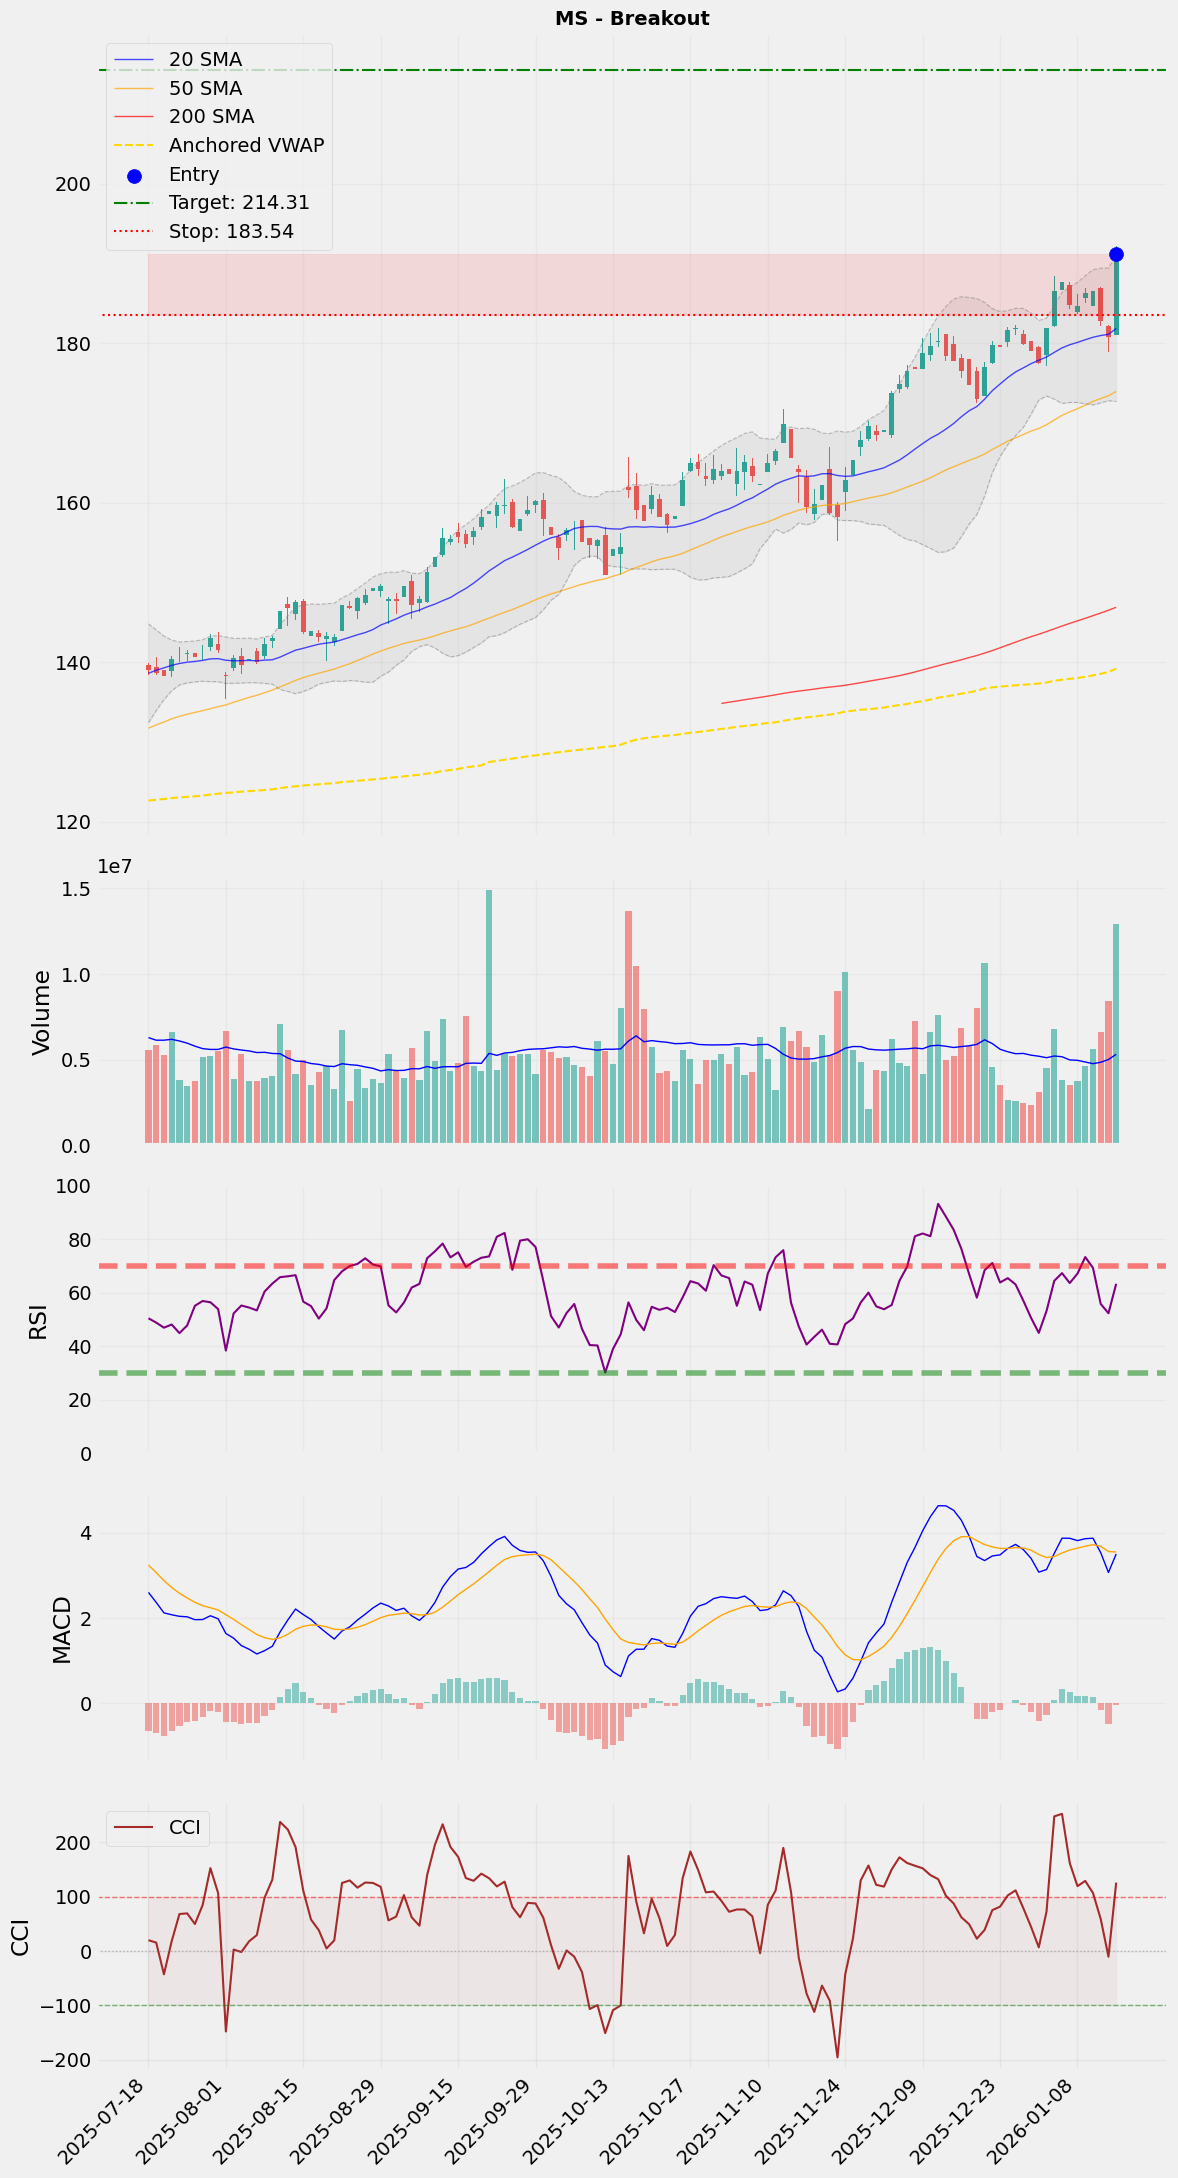

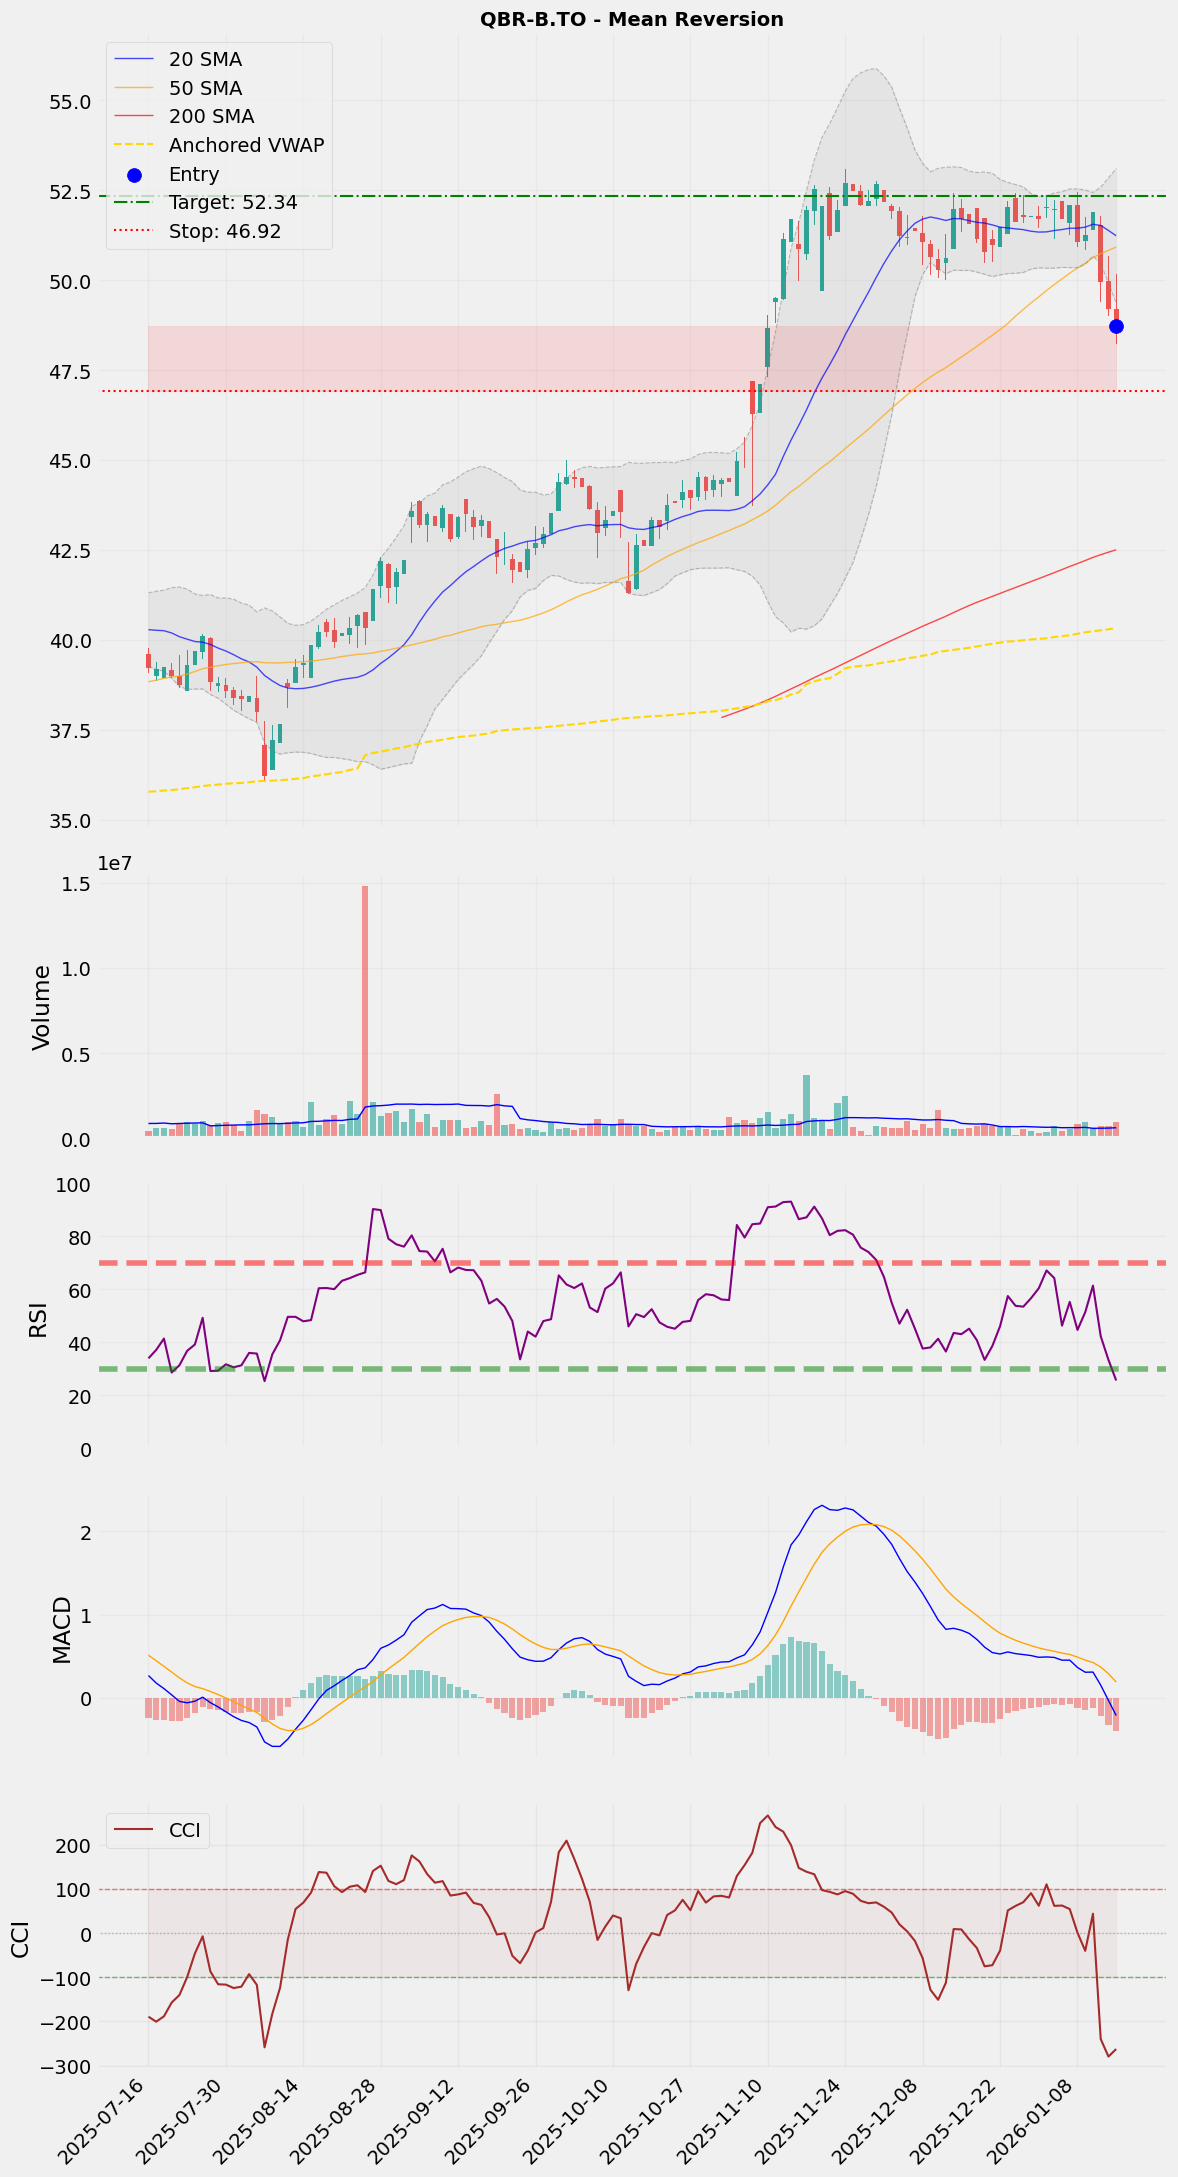

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_candidate(ticker, df, signal_type, target=None, stop=None, entry_price=None):
    # Slice last 6 months
    plot_df = df.iloc[-126:].copy()
    plot_df = plot_df.reset_index() # Reset index to use integer indexing for bars
    
    # Create 5 subplots: Price, Volume, RSI, MACD, CCI
    fig, (ax1, ax_vol, ax2, ax3, ax4) = plt.subplots(5, 1, figsize=(12, 22), sharex=True, 
                                                gridspec_kw={'height_ratios': [3, 1, 1, 1, 1]})
    
    # --- AX1: Candlestick Chart ---
    # Define width of candlestick elements
    width = 0.6
    width2 = 0.1
    
    # Define colors
    up_color = '#26a69a'   # Green
    down_color = '#ef5350' # Red
    
    # Separate up and down days
    up = plot_df[plot_df.Close >= plot_df.Open]
    down = plot_df[plot_df.Close < plot_df.Open]
    
    # Plot Up Candles
    ax1.bar(up.index, up.Close - up.Open, width, bottom=up.Open, color=up_color)
    ax1.bar(up.index, up.High - up.Close, width2, bottom=up.Close, color=up_color)
    ax1.bar(up.index, up.Low - up.Open, width2, bottom=up.Open, color=up_color)
    
    # Plot Down Candles
    ax1.bar(down.index, down.Close - down.Open, width, bottom=down.Open, color=down_color)
    ax1.bar(down.index, down.High - down.Open, width2, bottom=down.Open, color=down_color)
    ax1.bar(down.index, down.Low - down.Close, width2, bottom=down.Close, color=down_color)
    
    # Plot Moving Averages
    ax1.plot(plot_df.index, plot_df[f'SMA_{MA_SHORT}'], label=f'{MA_SHORT} SMA', color='blue', linewidth=1, alpha=0.7)
    ax1.plot(plot_df.index, plot_df[f'SMA_{MA_MED}'], label=f'{MA_MED} SMA', color='orange', linewidth=1, alpha=0.7)
    ax1.plot(plot_df.index, plot_df[f'SMA_{MA_LONG}'], label=f'{MA_LONG} SMA', color='red', linewidth=1, alpha=0.7)
    
    # Anchored VWAP
    if 'AVWAP' in plot_df.columns:
        ax1.plot(plot_df.index, plot_df['AVWAP'], label='Anchored VWAP', color='gold', linestyle='--', linewidth=1.5)

    # Bollinger Bands
    if 'BB_Upper' in plot_df.columns:
        ax1.plot(plot_df.index, plot_df['BB_Upper'], color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
        ax1.plot(plot_df.index, plot_df['BB_Lower'], color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
        ax1.fill_between(plot_df.index, plot_df['BB_Upper'], plot_df['BB_Lower'], color='gray', alpha=0.1)

    # Visuals: Targets & Stops
    last_idx = plot_df.index[-1]
    if entry_price:
        ax1.scatter(last_idx, entry_price, color='blue', s=100, zorder=5, label='Entry')
    if target:
        ax1.axhline(target, color='green', linestyle='-.', linewidth=1.5, label=f'Target: {target:.2f}')
    if stop:
        ax1.axhline(stop, color='red', linestyle=':', linewidth=1.5, label=f'Stop: {stop:.2f}')
        # Shade the risk area
        ax1.fill_between(plot_df.index, stop, entry_price, color='red', alpha=0.1)

    ax1.set_title(f"{ticker} - {signal_type}", fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.2)
    
    # --- AX_VOL: Volume ---
    ax_vol.bar(plot_df.index, plot_df['Volume'], color=np.where(plot_df['Close'] >= plot_df['Open'], up_color, down_color), alpha=0.6)
    
    # Add Volume SMA
    if 'Vol_SMA' in plot_df.columns:
        ax_vol.plot(plot_df.index, plot_df['Vol_SMA'], color='blue', linewidth=1, label='Vol SMA (20)')
    
    ax_vol.set_ylabel('Volume')
    ax_vol.grid(True, alpha=0.2)
    
    # --- AX2: RSI ---
    ax2.plot(plot_df.index, plot_df['RSI'], color='purple', linewidth=1.5)
    ax2.axhline(70, color='red', linestyle='--', alpha=0.5)
    ax2.axhline(30, color='green', linestyle='--', alpha=0.5)
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.2)
    
    # --- AX3: MACD ---
    ax3.plot(plot_df.index, plot_df['MACD'], color='blue', linewidth=1)
    ax3.plot(plot_df.index, plot_df['MACD_Signal'], color='orange', linewidth=1)
    ax3.bar(plot_df.index, plot_df['MACD_Hist'], color=np.where(plot_df['MACD_Hist']>=0, up_color, down_color), alpha=0.5)
    ax3.set_ylabel('MACD')
    ax3.grid(True, alpha=0.2)

    # --- AX4: CCI ---
    if 'CCI' in plot_df.columns:
        ax4.plot(plot_df.index, plot_df['CCI'], label='CCI', color='brown', linewidth=1.5)
        ax4.axhline(100, color='red', linestyle='--', linewidth=1, alpha=0.5)
        ax4.axhline(-100, color='green', linestyle='--', linewidth=1, alpha=0.5)
        ax4.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        ax4.fill_between(plot_df.index, 100, -100, color='brown', alpha=0.05)
        ax4.set_ylabel('CCI')
        ax4.legend(loc='upper left')
        ax4.grid(True, alpha=0.3)
    
    # Fix X-Axis Dates (Since we used integer indexing for bars)
    # Show every 10th date
    ticks = np.arange(0, len(plot_df), 10)
    ax4.set_xticks(ticks)
    
    # Handle Date column name (yfinance usually gives 'Date' or index)
    date_col = 'Date' if 'Date' in plot_df.columns else 'index'
    if date_col in plot_df.columns:
        ax4.set_xticklabels(plot_df[date_col].iloc[ticks].dt.strftime('%Y-%m-%d'), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Run the plotter on the results
if 'results_df' in locals() and not results_df.empty:
    
    # 1. Plot Pullbacks
    pullback_df = results_df[results_df['Signal'] == 'Pullback'].head(3)
    if not pullback_df.empty:
        print(f"\n--- Charting Top Pullback Setups ---")
        for index, row in pullback_df.iterrows():
            ticker = row['Ticker']
            if ticker in data_store:
                plot_candidate(ticker, data_store[ticker], row['Signal'], row.get('Target'), row.get('Stop'), row.get('Close'))

    # 2. Plot Retests
    retest_df = results_df[results_df['Signal'] == 'Retest'].head(3)
    if not retest_df.empty:
        print(f"\n--- Charting Top Retest Setups ---")
        for index, row in retest_df.iterrows():
            ticker = row['Ticker']
            if ticker in data_store:
                plot_candidate(ticker, data_store[ticker], row['Signal'], row.get('Target'), row.get('Stop'), row.get('Close'))
                
    # 3. Plot Others (Optional, maybe top 2)
    other_df = results_df[~results_df['Signal'].isin(['Pullback', 'Retest'])].head(2)
    if not other_df.empty:
        print(f"\n--- Charting Other Top Setups ---")
        for index, row in other_df.iterrows():
            ticker = row['Ticker']
            if ticker in data_store:
                plot_candidate(ticker, data_store[ticker], row['Signal'], row.get('Target'), row.get('Stop'), row.get('Close'))

else:
    print("No candidates to plot.")

# Manual Chart Analysis Tool

This cell provides an interactive tool for manual analysis of any stock, allowing users to generate detailed technical charts on-demand:

- **Ticker Selection**: Users can specify any ticker symbol (e.g., 'NVDA', 'TSLA', 'SHOP.TO') by modifying the `ticker_to_plot` variable. The code includes examples and comments for easy customization.

- **Data Retrieval Logic**: First checks if the ticker data is already cached from the scanner run (`data_store`). If not available, it downloads fresh data using the `download_data()` function and processes it with `calculate_indicators()` and `apply_strategies()`.

- **Signal Detection**: Analyzes the latest data point to determine if any active trading signals are present, updating the chart title accordingly (e.g., "Breakout (Active)", "Manual Analysis").

- **Chart Generation**: Uses the same `plot_candidate()` function as the automated charting, but focuses on manual analysis by passing the current close price as the entry point for visualization purposes.

- **Error Handling**: Provides clear feedback if data cannot be retrieved or processed, ensuring robust operation even with invalid tickers.

This tool enables traders to perform ad-hoc technical analysis on any stock of interest, complementing the automated scanner results with personalized research capabilities.

Generating chart for MFC.TO...


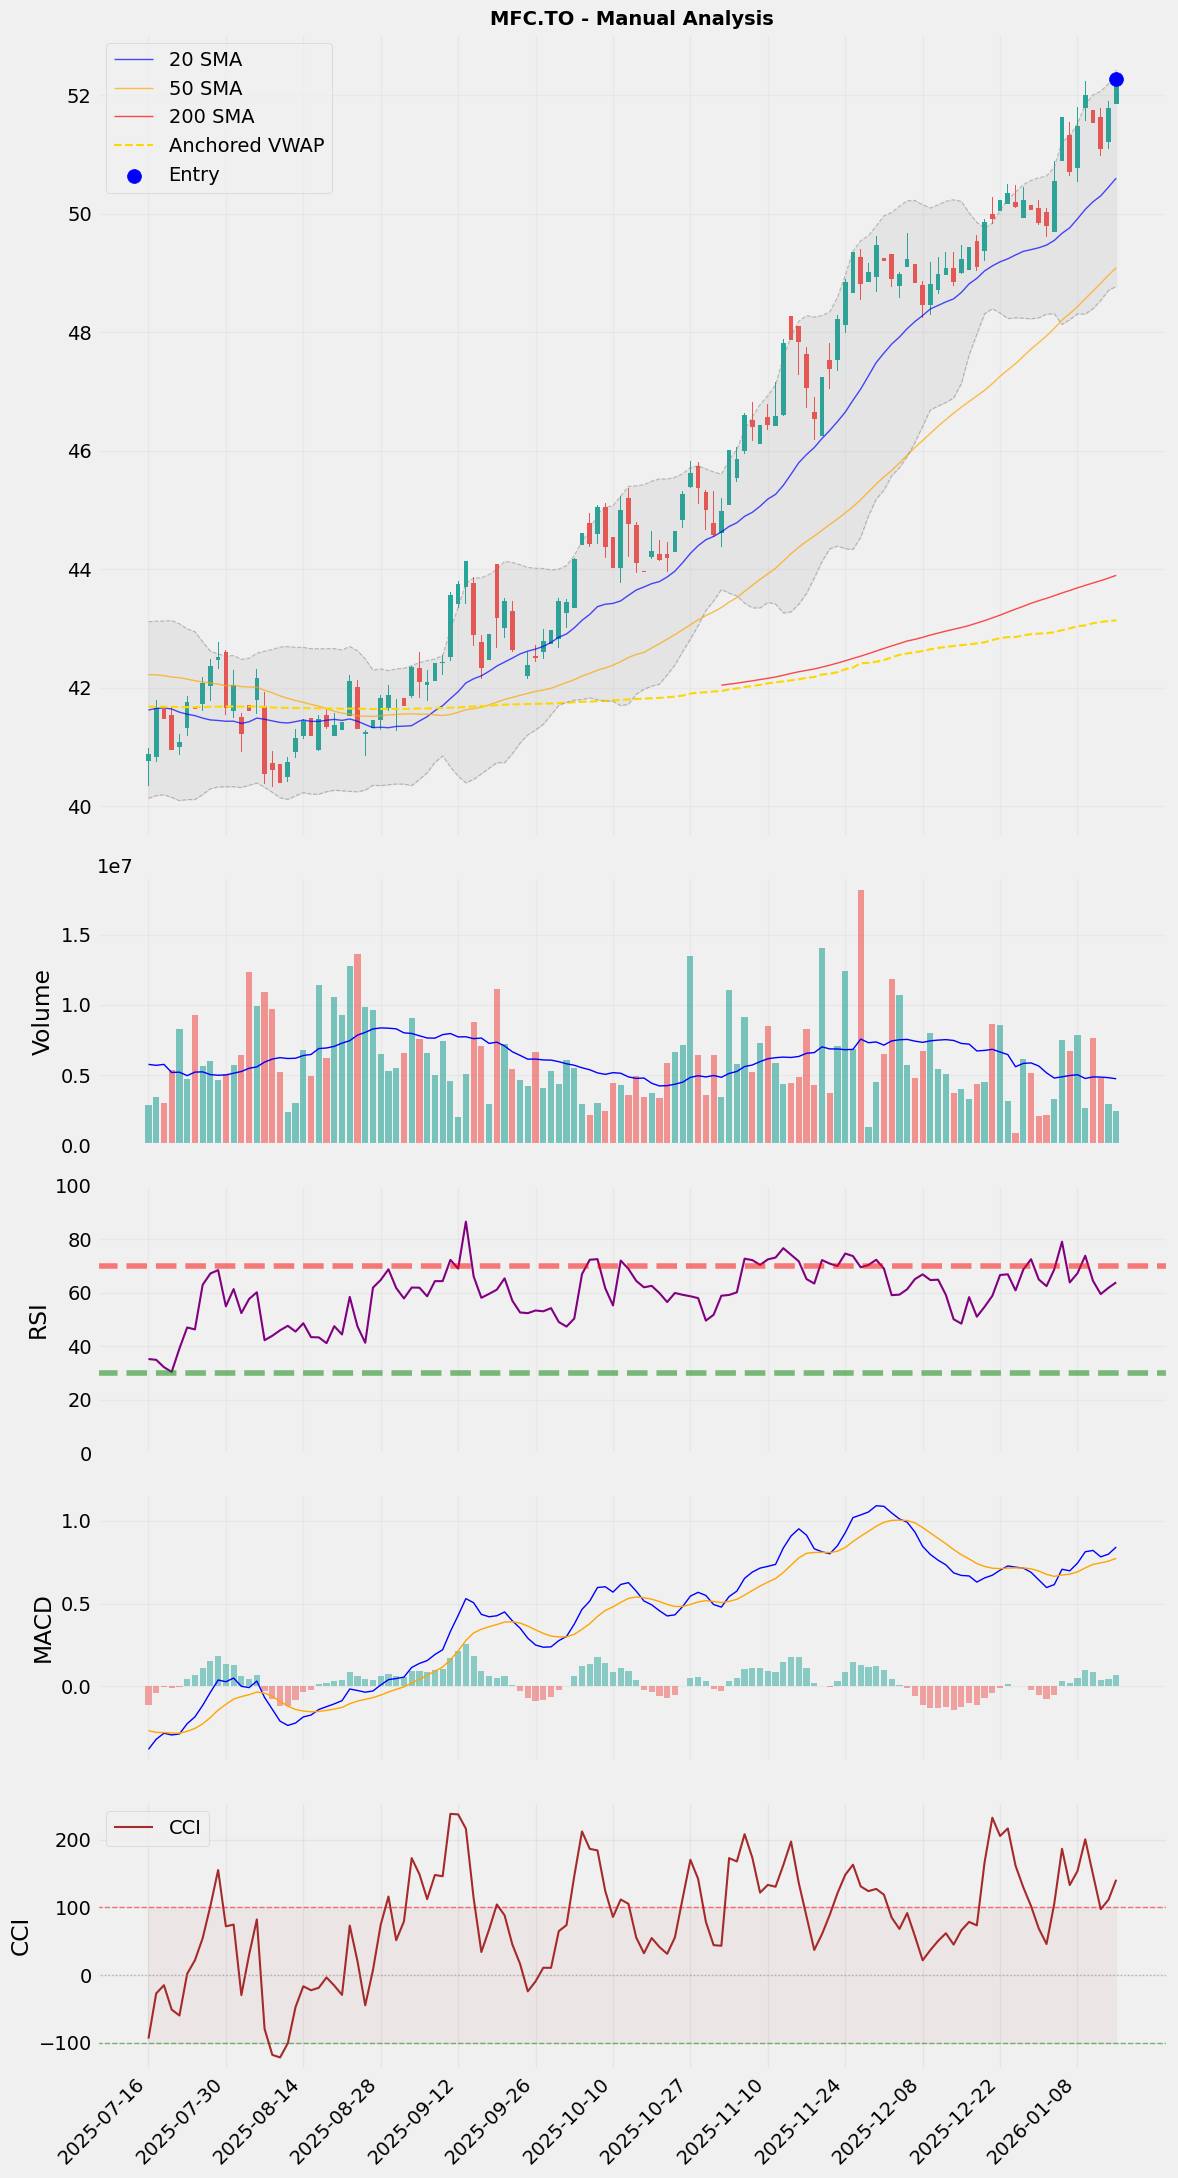

In [8]:
# --- Manual Charting ---
# Enter the ticker symbol you want to analyze
ticker_to_plot = 'MFC.TO'  # <--- Change this to your desired stock (e.g., 'NVDA', 'TSLA', 'SHOP.TO')

print(f"Generating chart for {ticker_to_plot}...")

# 1. Get Data
# Check if we already have the data from the scanner loop
if 'data_store' in locals() and ticker_to_plot in data_store:
    df_plot = data_store[ticker_to_plot]
    # Force re-calculation to ensure new indicators (like CCI) are present
    df_plot = calculate_indicators(df_plot)
else:
    # Download if not in memory
    print(f"Data not found in cache. Downloading {ticker_to_plot}...")
    data_dict = download_data([ticker_to_plot], START_DATE, END_DATE)
    if ticker_to_plot in data_dict:
        df_plot = calculate_indicators(data_dict[ticker_to_plot])
        # Apply strategies to see if any signals exist
        df_plot = apply_strategies(df_plot)
    else:
        df_plot = None
        print(f"Could not find data for {ticker_to_plot}")

# 2. Plot
if df_plot is not None and not df_plot.empty:
    # Check for active signals to display context
    latest_manual = df_plot.iloc[-1]
    manual_signal = "Manual Analysis"
    
    # Check if any strategy signals are active right now
    if 'Signal_Breakout' in df_plot.columns:
        if latest_manual['Signal_Breakout']: manual_signal = "Breakout (Active)"
        elif latest_manual['Signal_Pullback']: manual_signal = "Pullback (Active)"
        elif latest_manual['Signal_MeanRev']: manual_signal = "Mean Reversion (Active)"
    
    # Plot using the helper function
    # We pass the current close as the 'entry' for visualization purposes
    
    plot_candidate(
        ticker_to_plot, 
        df_plot, 
        signal_type=manual_signal,
        entry_price=latest_manual['Close'])
else:
    print("No data available to plot.")
